### 학습 데이터 범위
* 1안 [현안]  
: {양호 , 불량부분(파손된 부분)} 학습

~~*2안~~  
~~:{양호, 불량전체(파손된 부분을 포함하는 객체 전체를 의미하는 듯함), 불량부분} 학습~~

~~*3안~~  
~~:{불량부분} 학습~~


### label

배경 0 

점자블럭 1 (파손부)

보도블럭 2 (파손부)

자전거도로 3 (파손부)

### format 변환

한 객체에 대한 Bound 를 나타내는 다각형의 점들의 집합  
**P = [(x1, y1), (x2, y2), ... (xn, yn)]**
**P_X = [x1, x2, ... , xn]**
**P_Y = [y1, y2, ... , yn]**

P -> P' 으로 사이즈 변환 및 좌표값 Normalizing 매핑을 위해서는,  

**(사이즈 변환에 의한 좌표 조정값) X (Normalizing Term)**  

x_ratio = (target_width / origin_width) * (1 / target_width) = 1 / origin_width  

y_ratio = (target_height / origin_height) * (1 / target_height) = 1 / origin_height  

P' = [(x1', y1'), (x2', y2'), ... (xn', yn')]

P_X' = [x1' , x2', ... xn'] = x_ratio x P_X

P_Y' = [y1', y2', ...yn'] = y_ratio x P_Y


x_min = minimum x coordinate in P'

x_max = maximum x coordinate in P'

y_min = minimum y coordinate in P'

y_max = maximum y coordinate in P'

최종적으로 다음의 포맷으로 변환하기 위한 관계식은

**class_id, center_x, center_y, width, height**

width = (x_max - x_min)

height = (y_max - y_min)

center_x = (x_min + x_max) / 2

center_y = (y_min + y_max) / 2

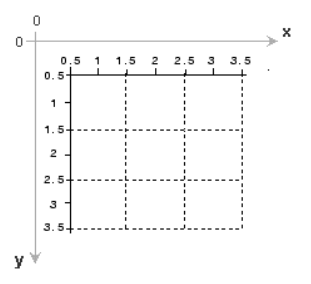  
이미지 좌표계  

### 함수 정의

In [49]:
import json
import numpy as np
# from PIL import Image

# 단순히 사용 데이터셋의 .json 파일에서 필요한 정보를 추출하는 함수
def get_bounding_boxes_from(data : json):
    bounding_box_list = []
    labels = {
              "점자블럭" : 0,
              "보도블록" : 1,
              "자전거 도로" : 2,
              }
    # 분류할 타입
    # is_defect = ["정상", "불량부분"]
    is_defect = ["불량부분"]
    
    # labels
    for object in data["annotations"]:
        # is_defect 내에 포함되지 않으면 bounding box 를 생성하지 않음
        if not object["is_defect"] in is_defect: continue

        ## label info parsing ##

        encoded_label = 0 # default value
        try:
            label_name = object["label_name"]
            encoded_label = labels[label_name]
        except :
            print(f"잘못된 label_name : {label_name}")
            return
        
        ## bounding box parsing ##

        x_min = y_min = 9999
        x_max = y_max = 0
        for vertex in object["annotation_info"]:
            x = vertex[0]
            y = vertex[1]
            x_max = max(x, x_max)
            x_min = min(x, x_min)
            y_max = max(y, y_max)
            y_min = min(y, y_min)

        bounding_box_list.append([encoded_label, x_min, x_max, y_min, y_max])
        # print(bounding_box_list)
    
    bounding_boxes = np.array(bounding_box_list)
    
    return bounding_boxes


# YOLO 모델의 .txt 라벨데이터 포맷에 맞게 Bounding box 정보 변환
# 정사각 이미지로 만들기 위해 padding 을 덧댄 경우
def trans_format_with_padding(bounding_boxes : np.ndarray, json_file : json):
    N_digits = 8
    # class_id center_x center_y width height  
    # 원본 이미지 사이즈
    width, height = json_file["info"]["width"], json_file["info"]["height"]

    long_edge = max(width, height)
    short_edge = min(width, height)
    
    padding = (long_edge - short_edge)/2
    
    target_size = 640.0 # 축소할 사이즈
    origin_size = long_edge # 패딩을 추가한 이미지는 long_edge X long_edge 의 사이즈가 된다.

    # where fields are space delimited, and the coordinates are normalized from zero to one.
    # Note: To convert to normalized xywh from pixel values, 
    # divide x (and width) by the image's width and divide y (and height) by the image's height.
    
    # (사이즈 변환에 의한 좌표 조정값) * (Normalizing Term)
    # (target_size / origin_size) * (1 / target_size) = 1 / origin_size
    ratio = round(1 / origin_size, ndigits=N_digits)

    objects = []
    for box in bounding_boxes:
        label = box[0]
    
        # width < heigth : 패딩이 x 축에만 추가
        # width > height : 패딩은 y 축에만 추가
        if (width < height) : 
            x_min = ratio * (box[1] + padding) # x_min
            x_max = ratio * (box[2] + padding) # x_max
            y_min = ratio * box[3] # y_min
            y_max = ratio * box[4] # y_max
        else:
            x_min = ratio * box[1] # x_min
            x_max = ratio * box[2] # x_max
            y_min = ratio * (box[3] + padding) # y_min
            y_max = ratio * (box[4] + padding)# y_max

    
        center_x = round((x_min + x_max)/2, ndigits=N_digits)
        center_y = round((y_min + y_max)/2, ndigits=N_digits)
        width = x_max - x_min
        height = y_max - y_min
        line = np.array([label, center_x, center_y, width, height])
        objects.append(line)

    return np.array(objects)

########################

def rotate_box(box : np.array, # [x_min, x_max, y_min, y_max]
               rotation_deg: float, # degrees
               rotation_center: tuple[float, float] # 회전중심
               ):
    
    cos_alpha = (np.cos(rotation_deg * np.pi / 180))
    sin_alpha = (np.sin(rotation_deg * np.pi / 180))

    x_min, x_max, y_min, y_max = box

    xo, yo = rotation_center

    # xo, yo 를 원점으로 하는 좌표계에서의 회전
    rotated_box = np.array([[cos_alpha*(x_min-xo) + sin_alpha*(y_min-yo), -sin_alpha*(x_min-xo) + cos_alpha*(y_min-yo)],
                            [cos_alpha*(x_min-xo) + sin_alpha*(y_max-yo), -sin_alpha*(x_min-xo) + cos_alpha*(y_max-yo)],
                            [cos_alpha*(x_max-xo) + sin_alpha*(y_min-yo), -sin_alpha*(x_max-xo) + cos_alpha*(y_min-yo)],
                            [cos_alpha*(x_max-xo) + sin_alpha*(y_max-yo), -sin_alpha*(x_max-xo) + cos_alpha*(y_max-yo)]])
    
    x_min = np.min(rotated_box[:, 0])
    x_max = np.max(rotated_box[:, 0])
    y_min = np.min(rotated_box[:, 1])
    y_max = np.max(rotated_box[:, 1])

    # 다시 (0,0) 을 원점으로 하는 원래 좌표계로 변환
    return np.array([x_min+xo, x_max+xo, y_min+yo, y_max+yo])

# 패딩을 덧대지 않은 경우
# 정사각형 사이즈 이미지가 아니기 때문에 좌표 변환 과정이 살짝 다르다.
# 좌표를 표준화 하며, 이미지 너비 높이 비율은 유지
def trans_format_without_padding(bounding_boxes : np.ndarray, # class_id center_x center_y width height  
                                 json_file : json,
                                 rotation_deg : float = 0): # counter-clockwise rotation
    N_digits = 8

    # 원본 이미지 사이즈
    original_width, original_height = json_file["info"]["width"], json_file["info"]["height"]

    rad_deg = rotation_deg * np.pi/180

    # calcultate the width and height of rotated image
    # PIL 에서 rotate 할 때 expanded=True 로 설정하면 회전된 이미지 사이즈는 올림처리하여 정수로 표현됨
    new_width = np.ceil(np.abs(original_width * np.cos(rad_deg)) + np.abs(original_height * np.sin(rad_deg)))
    new_height = np.ceil(np.abs(original_width * np.sin(rad_deg)) + np.abs(original_height * np.cos(rad_deg)))
    xo = new_width/2
    yo = new_height/2
    rotation_center = (xo, yo)

    print(new_width, new_height)

    # where fields are space delimited, and the coordinates are normalized from zero to one.
    # Note: To convert to normalized xywh from pixel values, 
    # divide x (and width) by the image's width and divide y (and height) by the image's height.
    # (사이즈 변환에 의한 좌표 조정값) * (Normalizing Term)
    # (target_width / width) * (1 / target_width) = 1 / width
    x_ratio = round(1 / new_width, ndigits=N_digits)
    y_ratio = round(1 / new_height, ndigits=N_digits)

    objects = []
    for box in bounding_boxes:
        label = box[0]

        xmin, xmax, ymin, ymax = box[1:]
        
        # counter-clockwise rotation
        # rotation_center 를 원점으로 하는 좌표계에서의 회전
        xmin, xmax, ymin, ymax = rotate_box(np.array([xmin, xmax, ymin, ymax]), 
                                                rotation_deg,
                                                rotation_center)
        # 회전 후 좌표계 다시 원래대로 변환
        # xmin += xo
        # xmax += xo
        # ymin += yo
        # ymax += yo

        # normarlize image coordinates
        xmin = xmin * x_ratio
        xmax = xmax * x_ratio
        ymin = ymin * y_ratio
        ymax = ymax * y_ratio

        
        # 경계를 벗어난 바운딩 박스
        if (xmin < 0 or xmax > new_width * x_ratio or ymin < 0 or ymax > new_height * y_ratio):
            print("Invalid bounding box : ", json_file['info']['filename'])
            print((new_width, new_height))
            print([xmin, xmax, ymin, ymax])
        

        # print(x_min, x_max, y_min, y_max)
            
        center_x = round((xmin + xmax)/2, ndigits=N_digits)
        center_y = round((ymin + ymax)/2, ndigits=N_digits)
        width = xmax - xmin
        height = ymax - ymin
        line = np.array([label, center_x, center_y, width, height])
        objects.append(line)

    return np.array(objects)

테스트 코드

In [50]:
### test code ###

# apple
# 2_09_1_1_1_1_20210719_0000006002.jpg
# samsung
# 2_09_1_1_1_1_20210716_0000037039.jpg


root_path = "D:/Downloads/street-facilities-selected"

# empty list [] 반환
# file = "2_09_0_1_4_1_20210927_0000569294" # 정상

file = "3_13_1_1_1_4_20210906_0000451979"


image_path = f"{root_path}/images/{file}.jpg" # .jpg or .jpeg
json_path = f"{root_path}/labels/{file}.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

bounding_boxes = get_bounding_boxes_from(data)

print(image_path)

print("bounding boxes")
for box in bounding_boxes:
    print(box)

# translated_format = trans_format_with_padding(bounding_boxes, data)
translated_format = trans_format_without_padding(bounding_boxes, data)
print("\ntranslated bounding boxes")
for t in translated_format:
    print(t)

translated_format = trans_format_without_padding(bounding_boxes, data, 45)
print("\ntranslated bounding boxes (rotation)")
for t in translated_format:
    print(t)

# np.savetxt(f"./{file}.txt", translated_format, delimiter=" ", fmt='%.8f')

D:/Downloads/street-facilities-selected/images/3_13_1_1_1_4_20210906_0000451979.jpg
bounding boxes
[2.00000000e+00 7.90491429e+00 2.26152411e+03 1.65888000e+03
 1.74528000e+03]
2268.0 4032.0

translated bounding boxes
[2.         0.50031832 0.42214988 0.99366578 0.02142893]
4455.0 4455.0

translated bounding boxes (rotation)
[2.         0.24315846 0.59006159 0.37141781 0.37141781]


In [48]:
bounding = np.array([7.90491429, 2261.52411, 1658.88000, 1745.28000]) # xmin xmax ymin ymax 2268 X 4032

bounding[:2] = bounding[:2]/2268
bounding[2:] = bounding[2:]/4032
center1 = ((bounding[0] + bounding[1])/2 , (bounding[2] + bounding[3])/2)
norm_width = bounding[1] - bounding[0]
norm_height = bounding[3] - bounding[2]
print(center1)
print(norm_width, norm_height)

(0.5003150406283069, 0.42214285714285715)
0.9936592573677249 0.021428571428571352


이미지 범위를 벗어나는 바운딩 박스 분석

In [8]:
import os
import json
import numpy as np

root_path = "D:/Downloads/street-facilities-selected"
json_path = f"{root_path}/labels"
save_path = "D:/Downloads/street-facilities-selected/labels-txt"

json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]

total = len(json_files)

for i, filename in enumerate(json_files):
    if(i%1000==0):
        print(f"{i+1} / {total}")
        
    filename = os.path.splitext(filename)[0] # .json 확장자명 제거
    # status = int(filename.split("_")[2]) # 0 : 정상 1 : 불량
    # class_id = int(filename.split("_")[1]) # 09 점자블록, 12 보도블록, 13 자전거도로

    with open(f"{json_path}/{filename}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
        width, height = data["info"]["width"], data["info"]["height"]
        bounding_boxes = get_bounding_boxes_from(data)

        # 정상적인 경우라면 yolo 모델이 학습시 이미지 크기를 벗어난 박스는 자동으로 제외하기는 한다.
        for box in bounding_boxes:
            xmin, xmax, ymin, ymax = box[1:]
            if (xmin < 0 or xmax > width or ymin < 0 or ymax > height) :
                print("Invalid bounding box ! : ", filename) 
                print([xmin, xmax, ymin, ymax])

        # translated_format = trans_format_without_padding(bounding_boxes, data)

1 / 8477
1001 / 8477
2001 / 8477
3001 / 8477
Invalid bounding box ! :  3_12_1_1_1_2_20210723_0000041318
[-8.185452315956354e-13, 2267.9999999999995, 0.0, 4032.0]
Invalid bounding box ! :  3_12_1_1_1_2_20210723_0000081454
[762.6633334802186, 1238.9356465140124, -1.0231815394945442e-14, 137.43157894736842]
4001 / 8477
5001 / 8477
6001 / 8477
Invalid bounding box ! :  3_13_1_1_1_1_20211016_0000645037
[1.6371902538353142e-13, 2268.1382484265705, 1356.528193643259, 1550.5260841531606]
Invalid bounding box ! :  3_13_1_1_1_3_20211016_0000644742
[9.533343863104445, 2268.1382484265705, 858.4117520045455, 1047.8194814750887]
7001 / 8477
8001 / 8477


### 변환

In [13]:
import os
import json
import numpy as np

root_path = "D:/Downloads/street-facilities-selected"
json_path = f"{root_path}/labels"
save_path = "D:/Downloads/street-facilities-selected/labels-txt"

json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]

total = len(json_files)

print(json_path)

# 폴더에 있는 .json 파일 순회
for i, filename in enumerate(json_files):
    if(i%300==0):
        print(f"{i+1} / {total}")
        
    filename = os.path.splitext(filename)[0] # .json 확장자명 제거
    status = int(filename.split("_")[2]) # 0 : 정상 1 : 불량
    class_id = int(filename.split("_")[1]) # 09 점자블록, 12 보도블록, 13 자전거도로

    with open(f"{json_path}/{filename}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
        bounding_boxes = get_bounding_boxes_from(data)
        # translated_format = trans_format_with_padding(bounding_boxes, data)
        translated_format = trans_format_without_padding(bounding_boxes, data)
        np.savetxt(f"{save_path}/{filename}.txt", translated_format, delimiter=" ", fmt='%.8f')

        #### data augmentation - counter-clockwise rotation 
        if status == 0: continue # 정상 (Negative samples) 은 증강 x
        else:
            for i, deg in enumerate([45, 90, 135]):
                # 클래스 분포 비율이 서로 비슷하도록 조정하여 증강
                # 클래스 분포 비율은 split.dataset.ipynb 에서 확인 가능
                # 원본 분포는 대략 09, 12, 13 => 1 : 3 : 2 
                if class_id == 12 and i > 0: break
                elif class_id == 13 and i > 1: break
                translated_format = trans_format_without_padding(bounding_boxes, data, deg)
                np.savetxt(f"{save_path}/{filename}-{i+1}.txt", translated_format, delimiter=" ", fmt='%.8f')

D:/Downloads/street-facilities-selected/labels
1 / 8477
301 / 8477
601 / 8477
901 / 8477
1201 / 8477
1501 / 8477
1801 / 8477
2101 / 8477
2401 / 8477
2701 / 8477
3001 / 8477
Invalid bounding box :  3_12_1_1_1_2_20210723_0000041318.jpg
(2268.0, 4032.0)
[-9.094947017729282e-13, 2267.9999999999995, 0.0, 4032.0]
3301 / 8477
3601 / 8477
3901 / 8477
4201 / 8477
4501 / 8477
4801 / 8477
5101 / 8477
5401 / 8477
5701 / 8477
6001 / 8477
6301 / 8477
Invalid bounding box :  3_13_1_1_1_1_20211016_0000645037.jpg
(2268.0, 4032.0)
[2.2737367544323206e-13, 2268.1382484265705, 2481.473915846839, 2675.4718063567407]
6601 / 8477
6901 / 8477
Invalid bounding box :  3_13_1_1_1_3_20211016_0000644742.jpg
(2268.0, 4032.0)
[9.533343863104392, 2268.1382484265705, 2984.1805185249113, 3173.5882479954544]
7201 / 8477
7501 / 8477
7801 / 8477
8101 / 8477
8401 / 8477


classId 는 Int 형이여야 하므로 이에 대한 처리 수행

In [ ]:
import os

root_path = "D:/Downloads/street-facilities-selected"

label_path = f"{root_path}/labels-txt"

labels = [label for label in os.listdir(label_path) if label.endswith('.txt')]
total_cnt = len(labels)

for i, label in enumerate(labels):
    if i % 1000 == 0 :
        print(f"{i+1} / {total_cnt}")
    annotations = []
    with open(os.path.join(label_path, label), "r+", encoding="utf-8") as f:
        # 기존 내용 읽기 및 수정
        for line in f:
            elems = line.split(" ")
            elems[0] = str(int(float(elems[0]))) # 1.00000000 -> 1 -> '1'
            newline = " ".join(elems)
            annotations.append(newline)
            
        # 새 내용 작성
        f.seek(0) # 파일 포인터 이동
        for annotation in annotations:
            f.write(annotation)
        f.truncate() # 파일 포인터 이전 내용만 남기고 나머지 삭제

1 / 19320
301 / 19320
601 / 19320
901 / 19320
1201 / 19320
1501 / 19320
1801 / 19320
2101 / 19320
2401 / 19320
2701 / 19320
3001 / 19320
3301 / 19320
3601 / 19320
3901 / 19320
4201 / 19320
4501 / 19320
4801 / 19320
5101 / 19320
5401 / 19320
5701 / 19320
6001 / 19320
6301 / 19320
6601 / 19320
6901 / 19320
7201 / 19320
7501 / 19320
7801 / 19320
8101 / 19320
8401 / 19320
8701 / 19320
9001 / 19320
9301 / 19320
9601 / 19320
9901 / 19320
10201 / 19320
10501 / 19320
10801 / 19320
11101 / 19320
11401 / 19320
11701 / 19320
12001 / 19320
12301 / 19320
12601 / 19320
12901 / 19320
13201 / 19320
13501 / 19320
13801 / 19320
14101 / 19320
14401 / 19320
14701 / 19320
15001 / 19320
15301 / 19320
15601 / 19320
15901 / 19320
16201 / 19320
16501 / 19320
16801 / 19320
17101 / 19320
17401 / 19320
17701 / 19320
18001 / 19320
18301 / 19320
18601 / 19320
18901 / 19320
19201 / 19320


누락된 파일 없는지 갯수 체크

In [ ]:
import os

root_path = "D:/Downloads/street-facilities-selected"
json_path = f"{root_path}/labels"
save_path = "D:/Downloads/street-facilities-selected/labels-txt"

json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]
json_total = len(json_files)
print("original json file counts : ", json_total)

txt_files = [f for f in os.listdir(save_path) if f.endswith('.txt')]
txt_total = len(txt_files)
print("txt file counts : ", txt_total)